In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
X, y = skds.fetch_openml("cardiotocography", return_X_y=True, version=2)
y[y=='1'] = 1
y[y=='2'] = 0
y[y=='3'] = 0

In [7]:
X = StandardScaler().fit_transform(X)


In [8]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(471, 35)
(1655, 35)


In [9]:
indices=np.arange(235)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:235]
x_train=np.concatenate((np.array(x_neg[0:235])[indices],x_pos)).reshape(-1,35)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[235:471].reshape(-1,35)
y_test = y_neg[235:471].reshape(-1,1)

# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [15]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [16]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(1655, 35)
Size: 10 Bits - FPR: 0.864407 - Time Taken to create Standard: 0.019768 - Time Taken to create Projecion: 1.615449 



Size: 20 Bits - FPR: 0.834746 - Time Taken to create Standard: 0.028218 - Time Taken to create Projecion: 1.733573 



Size: 30 Bits - FPR: 0.817797 - Time Taken to create Standard: 0.014704 - Time Taken to create Projecion: 0.668870 



Size: 40 Bits - FPR: 0.809322 - Time Taken to create Standard: 0.035825 - Time Taken to create Projecion: 0.938360 



Size: 50 Bits - FPR: 0.733051 - Time Taken to create Standard: 0.014912 - Time Taken to create Projecion: 0.618057 



Size: 60 Bits - FPR: 0.843220 - Time Taken to create Standard: 0.018924 - Time Taken to create Projecion: 0.548127 



Size: 70 Bits - FPR: 0.559322 - Time Taken to create Standard: 0.014183 - Time Taken to create Projecion: 0.547281 



Size: 80 Bits - FPR: 0.758475 - Time Taken to create Standard: 0.014799 - Time Taken to create Projecion: 1.149483 



Size:

Size: 690 Bits - FPR: 0.411017 - Time Taken to create Standard: 0.015330 - Time Taken to create Projecion: 0.703876 



Size: 700 Bits - FPR: 0.406780 - Time Taken to create Standard: 0.015735 - Time Taken to create Projecion: 0.704795 



Size: 710 Bits - FPR: 0.533898 - Time Taken to create Standard: 0.014506 - Time Taken to create Projecion: 0.618211 



Size: 720 Bits - FPR: 0.449153 - Time Taken to create Standard: 0.014837 - Time Taken to create Projecion: 0.574563 



Size: 730 Bits - FPR: 0.338983 - Time Taken to create Standard: 0.014608 - Time Taken to create Projecion: 0.578860 



Size: 740 Bits - FPR: 0.398305 - Time Taken to create Standard: 0.014283 - Time Taken to create Projecion: 0.555047 



Size: 750 Bits - FPR: 0.432203 - Time Taken to create Standard: 0.015485 - Time Taken to create Projecion: 0.589256 



Size: 760 Bits - FPR: 0.313559 - Time Taken to create Standard: 0.022253 - Time Taken to create Projecion: 0.699890 



Size: 770 Bits - FPR: 0.440678 - Time Ta

Size: 1370 Bits - FPR: 0.241525 - Time Taken to create Standard: 0.016620 - Time Taken to create Projecion: 1.168554 



Size: 1380 Bits - FPR: 0.262712 - Time Taken to create Standard: 0.020715 - Time Taken to create Projecion: 0.870764 



Size: 1390 Bits - FPR: 0.377119 - Time Taken to create Standard: 0.039406 - Time Taken to create Projecion: 0.766109 



Size: 1400 Bits - FPR: 0.292373 - Time Taken to create Standard: 0.020143 - Time Taken to create Projecion: 0.785214 



Size: 1410 Bits - FPR: 0.364407 - Time Taken to create Standard: 0.014953 - Time Taken to create Projecion: 0.805865 



Size: 1420 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.015048 - Time Taken to create Projecion: 0.774186 



Size: 1430 Bits - FPR: 0.313559 - Time Taken to create Standard: 0.064667 - Time Taken to create Projecion: 0.907927 



Size: 1440 Bits - FPR: 0.343220 - Time Taken to create Standard: 0.028855 - Time Taken to create Projecion: 0.797829 



Size: 1450 Bits - FPR: 0.309322 

Size: 2050 Bits - FPR: 0.427966 - Time Taken to create Standard: 0.015692 - Time Taken to create Projecion: 0.625521 



Size: 2060 Bits - FPR: 0.211864 - Time Taken to create Standard: 0.015415 - Time Taken to create Projecion: 0.642572 



Size: 2070 Bits - FPR: 0.237288 - Time Taken to create Standard: 0.013989 - Time Taken to create Projecion: 0.557258 



Size: 2080 Bits - FPR: 0.271186 - Time Taken to create Standard: 0.013577 - Time Taken to create Projecion: 0.600926 



Size: 2090 Bits - FPR: 0.381356 - Time Taken to create Standard: 0.018477 - Time Taken to create Projecion: 0.564729 



Size: 2100 Bits - FPR: 0.309322 - Time Taken to create Standard: 0.016665 - Time Taken to create Projecion: 0.551996 



Size: 2110 Bits - FPR: 0.211864 - Time Taken to create Standard: 0.014963 - Time Taken to create Projecion: 0.555838 



Size: 2120 Bits - FPR: 0.355932 - Time Taken to create Standard: 0.015862 - Time Taken to create Projecion: 0.579257 



Size: 2130 Bits - FPR: 0.292373 

Size: 2730 Bits - FPR: 0.207627 - Time Taken to create Standard: 0.022336 - Time Taken to create Projecion: 0.994493 



Size: 2740 Bits - FPR: 0.207627 - Time Taken to create Standard: 0.048881 - Time Taken to create Projecion: 1.257199 



Size: 2750 Bits - FPR: 0.254237 - Time Taken to create Standard: 0.026436 - Time Taken to create Projecion: 1.265621 



Size: 2760 Bits - FPR: 0.220339 - Time Taken to create Standard: 0.071144 - Time Taken to create Projecion: 1.611377 



Size: 2770 Bits - FPR: 0.262712 - Time Taken to create Standard: 0.016847 - Time Taken to create Projecion: 1.063059 



Size: 2780 Bits - FPR: 0.330508 - Time Taken to create Standard: 0.013715 - Time Taken to create Projecion: 1.022920 



Size: 2790 Bits - FPR: 0.258475 - Time Taken to create Standard: 0.030094 - Time Taken to create Projecion: 1.185716 



Size: 2800 Bits - FPR: 0.161017 - Time Taken to create Standard: 0.021151 - Time Taken to create Projecion: 1.553069 



Size: 2810 Bits - FPR: 0.199153 

Size: 410 Bits - FPR: 0.572034 - Time Taken to create Standard: 0.015662 - Time Taken to create Projecion: 0.560366 



Size: 420 Bits - FPR: 0.750000 - Time Taken to create Standard: 0.015416 - Time Taken to create Projecion: 0.577184 



Size: 430 Bits - FPR: 0.622881 - Time Taken to create Standard: 0.014040 - Time Taken to create Projecion: 0.530614 



Size: 440 Bits - FPR: 0.622881 - Time Taken to create Standard: 0.022026 - Time Taken to create Projecion: 0.540703 



Size: 450 Bits - FPR: 0.478814 - Time Taken to create Standard: 0.015115 - Time Taken to create Projecion: 0.561436 



Size: 460 Bits - FPR: 0.542373 - Time Taken to create Standard: 0.017285 - Time Taken to create Projecion: 0.559685 



Size: 470 Bits - FPR: 0.546610 - Time Taken to create Standard: 0.013856 - Time Taken to create Projecion: 0.567034 



Size: 480 Bits - FPR: 0.563559 - Time Taken to create Standard: 0.013784 - Time Taken to create Projecion: 0.533459 



Size: 490 Bits - FPR: 0.389831 - Time Ta

Size: 1100 Bits - FPR: 0.351695 - Time Taken to create Standard: 0.026701 - Time Taken to create Projecion: 0.983939 



Size: 1110 Bits - FPR: 0.351695 - Time Taken to create Standard: 0.020669 - Time Taken to create Projecion: 1.092557 



Size: 1120 Bits - FPR: 0.466102 - Time Taken to create Standard: 0.017696 - Time Taken to create Projecion: 1.001458 



Size: 1130 Bits - FPR: 0.355932 - Time Taken to create Standard: 0.049124 - Time Taken to create Projecion: 1.409442 



Size: 1140 Bits - FPR: 0.419492 - Time Taken to create Standard: 0.038340 - Time Taken to create Projecion: 1.119653 



Size: 1150 Bits - FPR: 0.461864 - Time Taken to create Standard: 0.044280 - Time Taken to create Projecion: 0.751734 



Size: 1160 Bits - FPR: 0.478814 - Time Taken to create Standard: 0.015869 - Time Taken to create Projecion: 0.623198 



Size: 1170 Bits - FPR: 0.512712 - Time Taken to create Standard: 0.015149 - Time Taken to create Projecion: 0.576198 



Size: 1180 Bits - FPR: 0.347458 

Size: 1780 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.019100 - Time Taken to create Projecion: 0.643314 



Size: 1790 Bits - FPR: 0.355932 - Time Taken to create Standard: 0.068684 - Time Taken to create Projecion: 0.664412 



Size: 1800 Bits - FPR: 0.305085 - Time Taken to create Standard: 0.019333 - Time Taken to create Projecion: 0.660984 



Size: 1810 Bits - FPR: 0.372881 - Time Taken to create Standard: 0.015848 - Time Taken to create Projecion: 0.651739 



Size: 1820 Bits - FPR: 0.148305 - Time Taken to create Standard: 0.017245 - Time Taken to create Projecion: 0.645529 



Size: 1830 Bits - FPR: 0.266949 - Time Taken to create Standard: 0.017479 - Time Taken to create Projecion: 0.691404 



Size: 1840 Bits - FPR: 0.343220 - Time Taken to create Standard: 0.019838 - Time Taken to create Projecion: 0.640806 



Size: 1850 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.015990 - Time Taken to create Projecion: 0.644513 



Size: 1860 Bits - FPR: 0.144068 

Size: 2460 Bits - FPR: 0.237288 - Time Taken to create Standard: 0.018550 - Time Taken to create Projecion: 0.678402 



Size: 2470 Bits - FPR: 0.258475 - Time Taken to create Standard: 0.019777 - Time Taken to create Projecion: 0.875626 



Size: 2480 Bits - FPR: 0.245763 - Time Taken to create Standard: 0.014551 - Time Taken to create Projecion: 0.845109 



Size: 2490 Bits - FPR: 0.177966 - Time Taken to create Standard: 0.024434 - Time Taken to create Projecion: 0.686337 



Size: 2500 Bits - FPR: 0.165254 - Time Taken to create Standard: 0.014605 - Time Taken to create Projecion: 1.017637 



Size: 2510 Bits - FPR: 0.216102 - Time Taken to create Standard: 0.018251 - Time Taken to create Projecion: 0.722403 



Size: 2520 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.049964 - Time Taken to create Projecion: 1.143963 



Size: 2530 Bits - FPR: 0.194915 - Time Taken to create Standard: 0.043653 - Time Taken to create Projecion: 1.039908 



Size: 2540 Bits - FPR: 0.139831 

Size: 140 Bits - FPR: 0.707627 - Time Taken to create Standard: 0.017038 - Time Taken to create Projecion: 0.569002 



Size: 150 Bits - FPR: 0.330508 - Time Taken to create Standard: 0.014602 - Time Taken to create Projecion: 1.009265 



Size: 160 Bits - FPR: 0.398305 - Time Taken to create Standard: 0.013457 - Time Taken to create Projecion: 0.547018 



Size: 170 Bits - FPR: 0.669492 - Time Taken to create Standard: 0.016497 - Time Taken to create Projecion: 0.519422 



Size: 180 Bits - FPR: 0.487288 - Time Taken to create Standard: 0.013516 - Time Taken to create Projecion: 0.564111 



Size: 190 Bits - FPR: 0.656780 - Time Taken to create Standard: 0.030080 - Time Taken to create Projecion: 0.914327 



Size: 200 Bits - FPR: 0.682203 - Time Taken to create Standard: 0.034145 - Time Taken to create Projecion: 1.150464 



Size: 210 Bits - FPR: 0.728814 - Time Taken to create Standard: 0.032091 - Time Taken to create Projecion: 0.707641 



Size: 220 Bits - FPR: 0.538136 - Time Ta

Size: 830 Bits - FPR: 0.334746 - Time Taken to create Standard: 0.013386 - Time Taken to create Projecion: 0.749112 



Size: 840 Bits - FPR: 0.432203 - Time Taken to create Standard: 0.032036 - Time Taken to create Projecion: 0.804685 



Size: 850 Bits - FPR: 0.504237 - Time Taken to create Standard: 0.020320 - Time Taken to create Projecion: 0.830849 



Size: 860 Bits - FPR: 0.432203 - Time Taken to create Standard: 0.017478 - Time Taken to create Projecion: 0.678774 



Size: 870 Bits - FPR: 0.355932 - Time Taken to create Standard: 0.016178 - Time Taken to create Projecion: 0.687724 



Size: 880 Bits - FPR: 0.402542 - Time Taken to create Standard: 0.012928 - Time Taken to create Projecion: 0.664852 



Size: 890 Bits - FPR: 0.385593 - Time Taken to create Standard: 0.019763 - Time Taken to create Projecion: 0.625547 



Size: 900 Bits - FPR: 0.300847 - Time Taken to create Standard: 0.024511 - Time Taken to create Projecion: 0.827478 



Size: 910 Bits - FPR: 0.406780 - Time Ta

Size: 1510 Bits - FPR: 0.364407 - Time Taken to create Standard: 0.015438 - Time Taken to create Projecion: 0.996113 



Size: 1520 Bits - FPR: 0.351695 - Time Taken to create Standard: 0.017624 - Time Taken to create Projecion: 0.927135 



Size: 1530 Bits - FPR: 0.334746 - Time Taken to create Standard: 0.014263 - Time Taken to create Projecion: 0.779699 



Size: 1540 Bits - FPR: 0.334746 - Time Taken to create Standard: 0.016542 - Time Taken to create Projecion: 0.805031 



Size: 1550 Bits - FPR: 0.220339 - Time Taken to create Standard: 0.046584 - Time Taken to create Projecion: 1.956244 



Size: 1560 Bits - FPR: 0.300847 - Time Taken to create Standard: 0.029073 - Time Taken to create Projecion: 1.312207 



Size: 1570 Bits - FPR: 0.322034 - Time Taken to create Standard: 0.022905 - Time Taken to create Projecion: 1.002088 



Size: 1580 Bits - FPR: 0.343220 - Time Taken to create Standard: 0.022744 - Time Taken to create Projecion: 0.522850 



Size: 1590 Bits - FPR: 0.338983 

Size: 2190 Bits - FPR: 0.199153 - Time Taken to create Standard: 0.018089 - Time Taken to create Projecion: 0.666932 



Size: 2200 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.015487 - Time Taken to create Projecion: 0.690258 



Size: 2210 Bits - FPR: 0.254237 - Time Taken to create Standard: 0.017495 - Time Taken to create Projecion: 0.567667 



Size: 2220 Bits - FPR: 0.203390 - Time Taken to create Standard: 0.017136 - Time Taken to create Projecion: 0.601182 



Size: 2230 Bits - FPR: 0.305085 - Time Taken to create Standard: 0.013316 - Time Taken to create Projecion: 0.588704 



Size: 2240 Bits - FPR: 0.245763 - Time Taken to create Standard: 0.015971 - Time Taken to create Projecion: 0.522940 



Size: 2250 Bits - FPR: 0.271186 - Time Taken to create Standard: 0.012195 - Time Taken to create Projecion: 0.444104 



Size: 2260 Bits - FPR: 0.271186 - Time Taken to create Standard: 0.015095 - Time Taken to create Projecion: 0.476403 



Size: 2270 Bits - FPR: 0.347458 

Size: 2870 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.029016 - Time Taken to create Projecion: 1.322058 



Size: 2880 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.024883 - Time Taken to create Projecion: 0.949498 



Size: 2890 Bits - FPR: 0.194915 - Time Taken to create Standard: 0.022353 - Time Taken to create Projecion: 0.759127 



Size: 2900 Bits - FPR: 0.186441 - Time Taken to create Standard: 0.026344 - Time Taken to create Projecion: 0.939974 



Size: 2910 Bits - FPR: 0.182203 - Time Taken to create Standard: 0.023973 - Time Taken to create Projecion: 1.144756 



Size: 2920 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.031237 - Time Taken to create Projecion: 1.033234 



Size: 2930 Bits - FPR: 0.207627 - Time Taken to create Standard: 0.022271 - Time Taken to create Projecion: 0.792791 



Size: 2940 Bits - FPR: 0.156780 - Time Taken to create Standard: 0.023476 - Time Taken to create Projecion: 0.825023 



Size: 2950 Bits - FPR: 0.241525 

Size: 550 Bits - FPR: 0.516949 - Time Taken to create Standard: 0.019396 - Time Taken to create Projecion: 0.702114 



Size: 560 Bits - FPR: 0.453390 - Time Taken to create Standard: 0.022093 - Time Taken to create Projecion: 0.689308 



Size: 570 Bits - FPR: 0.563559 - Time Taken to create Standard: 0.019364 - Time Taken to create Projecion: 0.838277 



Size: 580 Bits - FPR: 0.512712 - Time Taken to create Standard: 0.017382 - Time Taken to create Projecion: 0.659772 



Size: 590 Bits - FPR: 0.550847 - Time Taken to create Standard: 0.017906 - Time Taken to create Projecion: 1.038212 



Size: 600 Bits - FPR: 0.487288 - Time Taken to create Standard: 0.020168 - Time Taken to create Projecion: 1.421223 



Size: 610 Bits - FPR: 0.504237 - Time Taken to create Standard: 0.030696 - Time Taken to create Projecion: 0.978443 



Size: 620 Bits - FPR: 0.525424 - Time Taken to create Standard: 0.018526 - Time Taken to create Projecion: 0.775418 



Size: 630 Bits - FPR: 0.305085 - Time Ta

Size: 1240 Bits - FPR: 0.322034 - Time Taken to create Standard: 0.023220 - Time Taken to create Projecion: 0.742744 



Size: 1250 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.017726 - Time Taken to create Projecion: 0.781997 



Size: 1260 Bits - FPR: 0.389831 - Time Taken to create Standard: 0.017668 - Time Taken to create Projecion: 0.767999 



Size: 1270 Bits - FPR: 0.432203 - Time Taken to create Standard: 0.020733 - Time Taken to create Projecion: 0.733154 



Size: 1280 Bits - FPR: 0.338983 - Time Taken to create Standard: 0.020146 - Time Taken to create Projecion: 0.697768 



Size: 1290 Bits - FPR: 0.275424 - Time Taken to create Standard: 0.021643 - Time Taken to create Projecion: 0.862773 



Size: 1300 Bits - FPR: 0.292373 - Time Taken to create Standard: 0.024539 - Time Taken to create Projecion: 1.443485 



Size: 1310 Bits - FPR: 0.398305 - Time Taken to create Standard: 0.016888 - Time Taken to create Projecion: 1.225294 



Size: 1320 Bits - FPR: 0.389831 

Size: 1920 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.026479 - Time Taken to create Projecion: 0.820064 



Size: 1930 Bits - FPR: 0.190678 - Time Taken to create Standard: 0.024785 - Time Taken to create Projecion: 0.857359 



Size: 1940 Bits - FPR: 0.309322 - Time Taken to create Standard: 0.022901 - Time Taken to create Projecion: 0.829761 



Size: 1950 Bits - FPR: 0.203390 - Time Taken to create Standard: 0.028211 - Time Taken to create Projecion: 0.845209 



Size: 1960 Bits - FPR: 0.364407 - Time Taken to create Standard: 0.045010 - Time Taken to create Projecion: 0.870486 



Size: 1970 Bits - FPR: 0.322034 - Time Taken to create Standard: 0.022155 - Time Taken to create Projecion: 1.016215 



Size: 1980 Bits - FPR: 0.254237 - Time Taken to create Standard: 0.025836 - Time Taken to create Projecion: 0.916108 



Size: 1990 Bits - FPR: 0.122881 - Time Taken to create Standard: 0.027264 - Time Taken to create Projecion: 0.872352 



Size: 2000 Bits - FPR: 0.347458 

Size: 2600 Bits - FPR: 0.237288 - Time Taken to create Standard: 0.015460 - Time Taken to create Projecion: 0.672266 



Size: 2610 Bits - FPR: 0.317797 - Time Taken to create Standard: 0.018984 - Time Taken to create Projecion: 0.727041 



Size: 2620 Bits - FPR: 0.233051 - Time Taken to create Standard: 0.016535 - Time Taken to create Projecion: 1.412440 



Size: 2630 Bits - FPR: 0.254237 - Time Taken to create Standard: 0.037856 - Time Taken to create Projecion: 1.049968 



Size: 2640 Bits - FPR: 0.317797 - Time Taken to create Standard: 0.051212 - Time Taken to create Projecion: 1.420014 



Size: 2650 Bits - FPR: 0.326271 - Time Taken to create Standard: 0.020192 - Time Taken to create Projecion: 1.617322 



Size: 2660 Bits - FPR: 0.313559 - Time Taken to create Standard: 0.042257 - Time Taken to create Projecion: 1.023157 



Size: 2670 Bits - FPR: 0.211864 - Time Taken to create Standard: 0.030167 - Time Taken to create Projecion: 1.320295 



Size: 2680 Bits - FPR: 0.211864 

Size: 280 Bits - FPR: 0.716102 - Time Taken to create Standard: 0.018642 - Time Taken to create Projecion: 0.686045 



Size: 290 Bits - FPR: 0.474576 - Time Taken to create Standard: 0.019433 - Time Taken to create Projecion: 0.693842 



Size: 300 Bits - FPR: 0.444915 - Time Taken to create Standard: 0.019826 - Time Taken to create Projecion: 0.721743 



Size: 310 Bits - FPR: 0.576271 - Time Taken to create Standard: 0.028703 - Time Taken to create Projecion: 0.654248 



Size: 320 Bits - FPR: 0.644068 - Time Taken to create Standard: 0.018048 - Time Taken to create Projecion: 0.687660 



Size: 330 Bits - FPR: 0.572034 - Time Taken to create Standard: 0.017295 - Time Taken to create Projecion: 0.692991 



Size: 340 Bits - FPR: 0.453390 - Time Taken to create Standard: 0.014991 - Time Taken to create Projecion: 0.762659 



Size: 350 Bits - FPR: 0.546610 - Time Taken to create Standard: 0.020844 - Time Taken to create Projecion: 0.709810 



Size: 360 Bits - FPR: 0.572034 - Time Ta

Size: 970 Bits - FPR: 0.368644 - Time Taken to create Standard: 0.037902 - Time Taken to create Projecion: 1.133263 



Size: 980 Bits - FPR: 0.343220 - Time Taken to create Standard: 0.032056 - Time Taken to create Projecion: 0.879472 



Size: 990 Bits - FPR: 0.466102 - Time Taken to create Standard: 0.024167 - Time Taken to create Projecion: 0.860842 



Size: 1000 Bits - FPR: 0.389831 - Time Taken to create Standard: 0.022429 - Time Taken to create Projecion: 1.099149 



Size: 1010 Bits - FPR: 0.466102 - Time Taken to create Standard: 0.064868 - Time Taken to create Projecion: 1.309277 



Size: 1020 Bits - FPR: 0.262712 - Time Taken to create Standard: 0.025679 - Time Taken to create Projecion: 0.919085 



Size: 1030 Bits - FPR: 0.457627 - Time Taken to create Standard: 0.023933 - Time Taken to create Projecion: 0.869257 



Size: 1040 Bits - FPR: 0.444915 - Time Taken to create Standard: 0.019647 - Time Taken to create Projecion: 0.716048 



Size: 1050 Bits - FPR: 0.245763 - T

Size: 1650 Bits - FPR: 0.220339 - Time Taken to create Standard: 0.042735 - Time Taken to create Projecion: 1.498006 



Size: 1660 Bits - FPR: 0.343220 - Time Taken to create Standard: 0.047594 - Time Taken to create Projecion: 2.464352 



Size: 1670 Bits - FPR: 0.241525 - Time Taken to create Standard: 0.028552 - Time Taken to create Projecion: 1.182624 



Size: 1680 Bits - FPR: 0.207627 - Time Taken to create Standard: 0.020655 - Time Taken to create Projecion: 0.890239 



Size: 1690 Bits - FPR: 0.216102 - Time Taken to create Standard: 0.016838 - Time Taken to create Projecion: 0.918526 



Size: 1700 Bits - FPR: 0.296610 - Time Taken to create Standard: 0.018391 - Time Taken to create Projecion: 0.657668 



Size: 1710 Bits - FPR: 0.288136 - Time Taken to create Standard: 0.024732 - Time Taken to create Projecion: 1.444474 



Size: 1720 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.091121 - Time Taken to create Projecion: 1.367335 



Size: 1730 Bits - FPR: 0.317797 

Size: 2330 Bits - FPR: 0.322034 - Time Taken to create Standard: 0.018616 - Time Taken to create Projecion: 0.685517 



Size: 2340 Bits - FPR: 0.305085 - Time Taken to create Standard: 0.013398 - Time Taken to create Projecion: 0.571123 



Size: 2350 Bits - FPR: 0.250000 - Time Taken to create Standard: 0.012739 - Time Taken to create Projecion: 0.497591 



Size: 2360 Bits - FPR: 0.186441 - Time Taken to create Standard: 0.013464 - Time Taken to create Projecion: 0.485778 



Size: 2370 Bits - FPR: 0.190678 - Time Taken to create Standard: 0.016943 - Time Taken to create Projecion: 0.858314 



Size: 2380 Bits - FPR: 0.241525 - Time Taken to create Standard: 0.024349 - Time Taken to create Projecion: 0.667165 



Size: 2390 Bits - FPR: 0.262712 - Time Taken to create Standard: 0.014337 - Time Taken to create Projecion: 0.613552 



Size: 2400 Bits - FPR: 0.165254 - Time Taken to create Standard: 0.012269 - Time Taken to create Projecion: 0.968251 



Size: 2410 Bits - FPR: 0.148305 

In [17]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [18]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [19]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [21]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [22]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

1500
[1655]


# FPR Comparison between Projection Model and Normal Bloom Filter

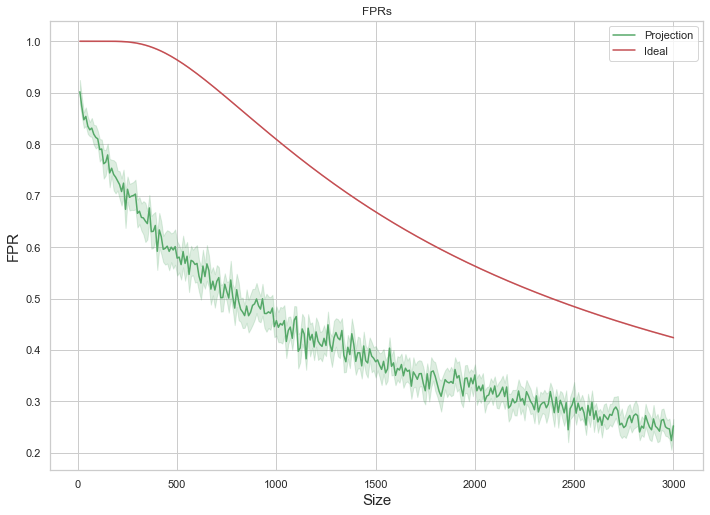

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [21]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [22]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [23]:
print(average_fprs)

[0.9016949152542372, 0.8722457627118645, 0.8472457627118646, 0.8538135593220337, 0.8347457627118644, 0.8277542372881357, 0.8311440677966102, 0.8192796610169492, 0.8131355932203391, 0.8101694915254237, 0.7894067796610169, 0.7904661016949152, 0.761864406779661, 0.7648305084745762, 0.7790254237288137, 0.7440677966101694, 0.7531779661016949, 0.7411016949152541, 0.7358050847457629, 0.7283898305084746, 0.7213983050847459, 0.7078389830508474, 0.7241525423728815, 0.6733050847457627, 0.7122881355932204, 0.6966101694915254, 0.6989406779661019, 0.7002118644067796, 0.7029661016949152, 0.6654661016949153, 0.6697033898305086, 0.6576271186440679, 0.6565677966101694, 0.6504237288135594, 0.6455508474576271, 0.6760593220338983, 0.6298728813559322, 0.6307203389830509, 0.641949152542373, 0.5917372881355931, 0.6332627118644067, 0.6203389830508474, 0.5955508474576272, 0.597457627118644, 0.6016949152542372, 0.5915254237288134, 0.5997881355932205, 0.5942796610169492, 0.6008474576271186, 0.5783898305084746, 0.

In [25]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.0,0.019768,0.020591,0.864407,0.866102,1.615449,0.950616
1,20,1.0,0.028218,0.030525,0.834746,0.803390,1.733573,0.971328
2,30,1.0,0.014704,0.022349,0.817797,0.821186,0.668870,0.660495
3,40,1.0,0.035825,0.021371,0.809322,0.670339,0.938360,0.788698
4,50,1.0,0.014912,0.016578,0.733051,0.741525,0.618057,0.648770


In [26]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Cardio_rerun_epochs_100.csv')